# Classification: Marine climate

### Imports y config básica

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

np.random.seed(42)
plt.rcParams["font.size"] = 12

import warnings

warnings.filterwarnings("ignore")

### PARTE 1: CARGA y EXPLORACION DEL DATASET

In [ ]:
data = pd.read_csv("data/MarineClimate.csv")
data.head()
# data.describe()

,WindSpeed,WindDirection,Period,Pressure,WaveHeight,ExtremeWaves
0,18.108904,18.605420,5.196156,998.315450,3.344766,1
1,38.275001,191.287667,6.621674,991.061288,5.207742,1
2,30.619788,194.628644,5.301136,997.257417,3.915018,1
3,25.953047,229.474765,4.153133,1013.321662,4.480600,1
4,10.460652,261.392880,4.568266,1006.856982,0.818609,0


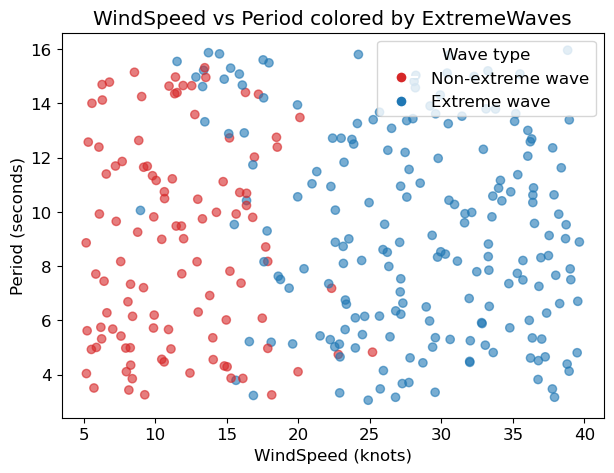

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize=(7, 5))

# Colores según HighWave (0 = no extrema, 1 = extrema)
colors = data["ExtremeWaves"].map({0: "tab:red", 1: "tab:blue"})

# Scatter correcto: WindSpeed vs Period
ax.scatter(data["WindSpeed"], data["Period"], c=colors, alpha=0.6)

ax.set_xlabel("WindSpeed (knots)")
ax.set_ylabel("Period (seconds)")
ax.set_title("WindSpeed vs Period colored by ExtremeWaves")

from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Non-extreme wave",
        markerfacecolor="tab:red",
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Extreme wave",
        markerfacecolor="tab:blue",
        markersize=8,
    ),
]
ax.legend(handles=legend_elements, title="Wave type")

plt.show()

### PARTE 2: Seleccionar variables y crear train / test

Para que podamos dibujar fronteras de decisión, usaremos solo 2 predictores: WindSpeed y Period.

In [ ]:
# Predictores: WindSpeed y Period
X = data[["WindSpeed", "Period"]].values
y = data["ExtremeWaves"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

len(X_train), len(X_test)

(210, 90)

### PARTE 3: Ajustar modelos: logística, LDA, QDA

In [ ]:
# 1. Regresión logística
log_reg = LogisticRegression(
    solver="liblinear"
)  # solver simple para binario --> algoritmo que realiza la optimización iterativa (RL maximiza la verosimilitud/minimiza pérdida))-liblinear es estable y rapido para RL con datasets pequeños/medianos
log_reg.fit(X_train, y_train)

# 2. LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# 3. QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Predicciones
y_pred_log = log_reg.predict(X_test)
y_pred_lda = lda.predict(X_test)
y_pred_qda = qda.predict(X_test)

# Accuracy
acc_log = accuracy_score(y_test, y_pred_log)
acc_lda = accuracy_score(y_test, y_pred_lda)
acc_qda = accuracy_score(y_test, y_pred_qda)

print(f"Accuracy test - Regresión logística: {acc_log:.3f}")
print(f"Accuracy test - LDA:                 {acc_lda:.3f}")
print(f"Accuracy test - QDA:                 {acc_qda:.3f}")

Accuracy test - Regresión logística: 0.944
Accuracy test - LDA:                 0.944
Accuracy test - QDA:                 0.933


### PARTE 4: Matrices de confusión y classification report

In [ ]:
models = {"Logistic": y_pred_log, "LDA": y_pred_lda, "QDA": y_pred_qda}

for name, y_pred in models.items():
    print(f"\n=== {name} ===")
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    print(cm)
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))


=== Logistic ===
Matriz de confusión:
[[31  5]
 [ 0 54]]

Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        36
           1       0.92      1.00      0.96        54

    accuracy                           0.94        90
   macro avg       0.96      0.93      0.94        90
weighted avg       0.95      0.94      0.94        90


=== LDA ===
Matriz de confusión:
[[35  1]
 [ 4 50]]

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        36
           1       0.98      0.93      0.95        54

    accuracy                           0.94        90
   macro avg       0.94      0.95      0.94        90
weighted avg       0.95      0.94      0.94        90


=== QDA ===
Matriz de confusión:
[[34  2]
 [ 4 50]]

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92   

### PARTE 5: Visualizar fronteras de decisión

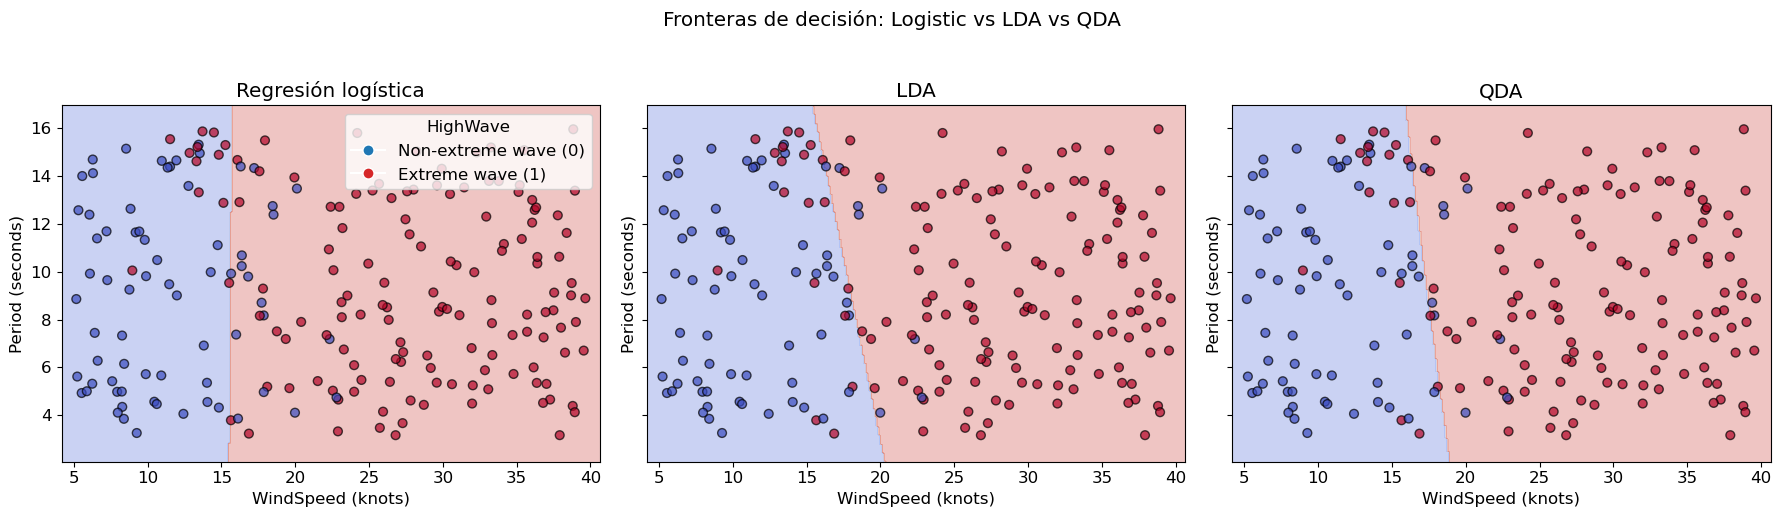

In [ ]:
# Crear una malla (grid) para dibujar las fronteras
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # WindSpeed
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Period

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

# Grid de puntos (cada fila es [WindSpeed, Period])
grid = np.c_[xx.ravel(), yy.ravel()]

# Predicciones en la malla
Z_log = log_reg.predict(grid).reshape(xx.shape)
Z_lda = lda.predict(grid).reshape(xx.shape)
Z_qda = qda.predict(grid).reshape(xx.shape)

# Preparar gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

titles = ["Regresión logística", "LDA", "QDA"]
Zs = [Z_log, Z_lda, Z_qda]

for ax, Z, title in zip(axes, Zs, titles):
    # Región de decisión
    ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

    # Puntos de entrenamiento coloreados por HighWave (0/1)
    ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c=y_train,
        cmap="coolwarm",
        edgecolor="k",
        s=40,
        alpha=0.7,
    )

    ax.set_title(title)
    ax.set_xlabel("WindSpeed (knots)")
    ax.set_ylabel("Period (seconds)")

# Leyenda manual
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Non-extreme wave (0)",
        markerfacecolor="tab:blue",
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Extreme wave (1)",
        markerfacecolor="tab:red",
        markersize=8,
    ),
]
axes[0].legend(handles=legend_elements, title="HighWave")

plt.suptitle("Fronteras de decisión: Logistic vs LDA vs QDA", y=1.03)
plt.tight_layout()
plt.show()